In [1]:
import numpy as np
import pandas as pd

In [2]:
def generate_time_series(sample_size, n_steps): 
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, sample_size, 1) 
    time = np.linspace(0, 1, n_steps) 
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) #wave1+ 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #wave2+ 
    series += 0.1 * (np.random.rand(sample_size, n_steps) - 0.5)  #noise 
    return series[..., np.newaxis].astype(np.float32)

### A) Create a dataset of 10,000 samples with 51 time steps each (Note: the 51st time step should be used as the label) 

In [3]:
n_samples = 10000
n_steps = 51  #51 time steps for each sample

series = generate_time_series(n_samples, n_steps)

In [4]:
series

array([[[ 5.33108950e-01],
        [ 5.78765333e-01],
        [ 5.99578381e-01],
        ...,
        [-3.18694025e-01],
        [-2.46697769e-01],
        [-7.14478493e-02]],

       [[-1.17008492e-01],
        [-2.50472158e-01],
        [-2.74305999e-01],
        ...,
        [ 2.42757380e-01],
        [ 1.61387980e-01],
        [ 1.81313053e-01]],

       [[ 1.97881371e-01],
        [ 1.70884997e-01],
        [ 1.45878315e-01],
        ...,
        [-3.11361790e-01],
        [-3.04368883e-01],
        [-3.05303723e-01]],

       ...,

       [[-2.30060726e-01],
        [ 3.14158184e-04],
        [ 3.27978075e-01],
        ...,
        [-4.62512448e-02],
        [-2.49873996e-01],
        [-5.08564591e-01]],

       [[-6.84796572e-01],
        [-6.51894152e-01],
        [-4.81109709e-01],
        ...,
        [-1.30150616e-01],
        [ 8.55597630e-02],
        [ 3.06018293e-01]],

       [[ 3.11733842e-01],
        [ 3.16560119e-01],
        [ 2.54231960e-01],
        ...,
        

In [5]:
# Split into input features and labels
X = series[:, :50]  # First 50 time steps are input
y = series[:, 50]   # 51st time step is the label

In [6]:
X.shape

(10000, 50, 1)

In [7]:
y.shape

(10000, 1)

### B) Split the dataset in the ratio training: validation: testing = 70:20:10. 

In [8]:
from sklearn.model_selection import train_test_split

# 10% testing, 90% training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2222, random_state=42)
#test size is 0.2222, which is calculated as 0.2222 ≈ 2 / 9 to make the validation set 20% of the total dataset.
#=>22.2222% of 90%(training)

print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)  # 7000 samples
print("Validation set shape (X_val, y_val):", X_val.shape, y_val.shape)        # 2000 samples
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)       # 1000 samples

Training set shape (X_train, y_train): (7000, 50, 1) (7000, 1)
Validation set shape (X_val, y_val): (2000, 50, 1) (2000, 1)
Testing set shape (X_test, y_test): (1000, 50, 1) (1000, 1)


In [9]:
X_train.shape

(7000, 50, 1)

In [10]:
X[0, :, 0].shape

(50,)

### Visualizing dataset

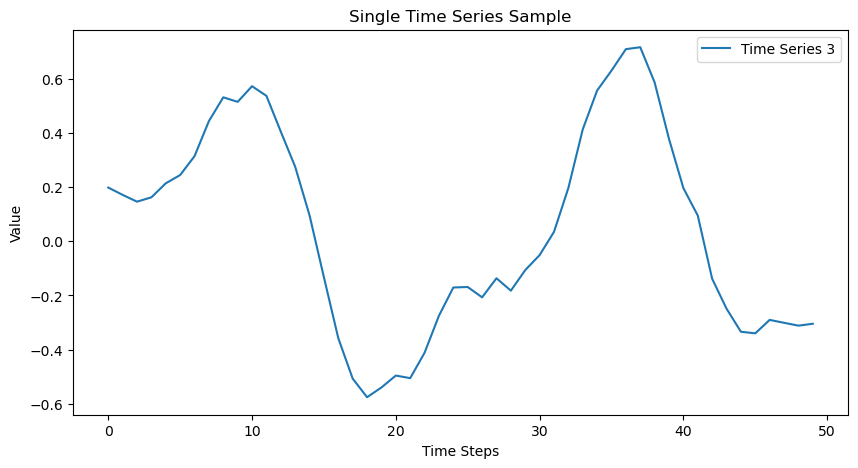

In [11]:
import matplotlib.pyplot as plt

# Visualize a single time series (e.g., the 3rd sample)
plt.figure(figsize=(10, 5))
plt.plot(X[2, :,0], label='Time Series 3')  # X[0, :, 0] extracts one sample, 50 time steps,(X[0, :] also works, shape(50,1))
plt.title("Single Time Series Sample")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


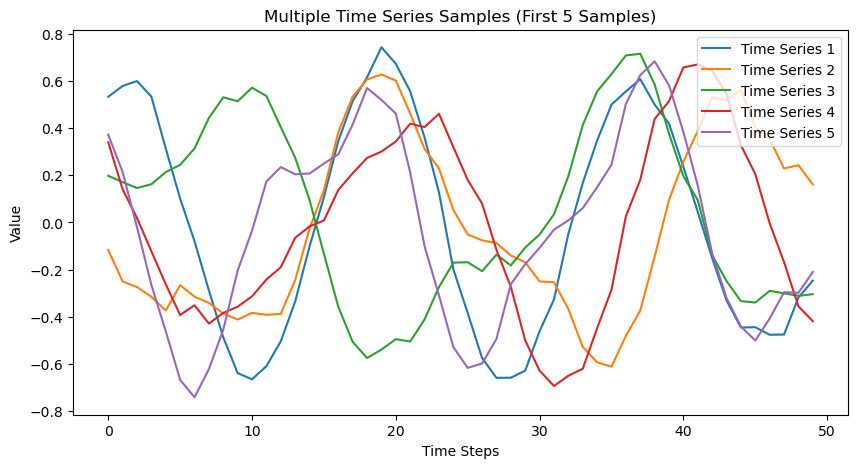

In [12]:
# Visualize the first 5 time series
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(np.arange(50), X[i, :, 0], label=f'Time Series {i+1}')
plt.title("Multiple Time Series Samples (First 5 Samples)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


### C) Design, train, test and compare the performances of the following on the prediction of the value of 51st time step in the generated time series. 
- i. Fully connected neural network. 
- ii. Simple RNN with one hidden layer and one output layer. 
- iii. Simple RNN with two hidden layers and one output layer.

## i. Fully connected neural network.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

#Before Flatten:  [[t1], [t2], [t3], ..., [t50]]  ->  Shape: (50, 1)
#After Flatten:   [t1, t2, t3, ..., t50]         ->  Shape: (50,)
fcnn_model = Sequential([
    Flatten(input_shape=(50, 1)),         # Flattening the input time series (50 timesteps)
    Dense(128, activation='relu'),        
    Dense(64, activation='relu'),         
    Dense(1)                             
])

fcnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14849 (58.00 KB)
Trainable params: 14849 (58.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
fcnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
fcnn_history = fcnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0155 - mae: 0.0892 - val_loss: 0.0048 - val_mae: 0.0552
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0043 - mae: 0.0526 - val_loss: 0.0045 - val_mae: 0.0536
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0035 - mae: 0.0472 - val_loss: 0.0043 - val_mae: 0.0521
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0034 - mae: 0.0464 - val_loss: 0.0037 - val_mae: 0.0491
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0030 - mae: 0.0438 - val_loss: 0.0033 - val_mae: 0.0468
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0028 - mae: 0.0426 - val_loss: 0.0033 - val_mae: 0.0460
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0026 - mae: 0.0408 - val_loss: 0.0030 - val_mae: 0.0443
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.

In [15]:
fcnn_results = fcnn_model.evaluate(X_test, y_test)
fcnn_results

32/32 [==============================] - 0s 3ms/step - loss: 0.0027 - mae: 0.0418


[0.0027005013544112444, 0.041836317628622055]

In [16]:
results=[]
evaluation=[]
results.append({'model':'FCNN','loss':fcnn_history.history['loss'][-1],'mae':fcnn_history.history['mae'][-1],'val_loss':fcnn_history.history['val_loss'][-1],'val_mae':fcnn_history.history['val_mae'][-1]})
evaluation.append({'model':'FCNN','MSE':fcnn_results[0],'MAE':fcnn_results[1]})

In [17]:
 # Generate predictions for the test data (for the 51st time step)
y_pred = fcnn_model.predict(X_test)

32/32 [==============================] - 0s 3ms/step


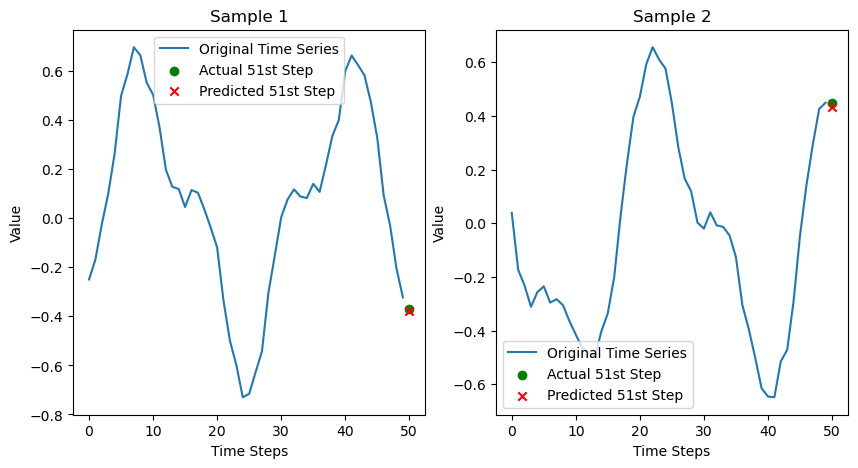

In [18]:
import matplotlib.pyplot as plt
num_samples = 2
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(1, 2, i+1)
    plt.plot(np.arange(50), X_test[i, :, 0], label="Original Time Series")
    
    # Ploting actual 51st time step
    plt.scatter(50, y_test[i], color='green', label="Actual 51st Step", marker='o')

    # Plot predicted 51st time step
    plt.scatter(50, y_pred[i], color='red', label="Predicted 51st Step", marker='x')
    
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.show()

## ii. Simple RNN with one hidden layer and one output layer.

In [19]:
from tensorflow.keras.layers import SimpleRNN

rnn_model_1 = Sequential([
    SimpleRNN(64, input_shape=(50, 1),return_sequences=True),   # 64 neurons in layer1
    Dense(1)                             
])
rnn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 64)            4224      
                                                                 
 dense_3 (Dense)             (None, 50, 1)             65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
rnn_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_history_1 = rnn_model_1.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 7s 21ms/step - loss: 0.1304 - mae: 0.3058 - val_loss: 0.1057 - val_mae: 0.2685
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0991 - mae: 0.2567 - val_loss: 0.0949 - val_mae: 0.2499
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0899 - mae: 0.2421 - val_loss: 0.0886 - val_mae: 0.2384
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0862 - mae: 0.2362 - val_loss: 0.0829 - val_mae: 0.2309
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0826 - mae: 0.2307 - val_loss: 0.0813 - val_mae: 0.2285
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0810 - mae: 0.2272 - val_loss: 0.0824 - val_mae: 0.2309
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0789 - mae: 0.2241 - val_loss: 0.0769 - val_mae: 0.2213
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - 

In [21]:
rnn_results_1 = rnn_model_1.evaluate(X_test, y_test)
results.append({'model':'RNN_1layer','loss':rnn_history_1.history['loss'][-1],'mae':rnn_history_1.history['mae'][-1],'val_loss':rnn_history_1.history['val_loss'][-1],'val_mae':rnn_history_1.history['val_mae'][-1]})
evaluation.append({'model':'RNN_1layer','MSE':rnn_results_1[0],'MAE':rnn_results_1[1]})

32/32 [==============================] - 0s 8ms/step - loss: 0.0663 - mae: 0.2037


### iii. Simple RNN with 2 hidden layers and one output layer.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

rnn_model_2 = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(50, 1)), 
    SimpleRNN(32),                                              
    Dense(1)                                                   
])

rnn_model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50, 64)            4224      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7361 (28.75 KB)
Trainable params: 7361 (28.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
rnn_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])
rnn_history_2 = rnn_model_2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
219/219 [==============================] - 12s 38ms/step - loss: 0.0156 - mae: 0.0815 - val_loss: 0.0039 - val_mae: 0.0497
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0037 - mae: 0.0486 - val_loss: 0.0045 - val_mae: 0.0541
Epoch 3/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0031 - mae: 0.0447 - val_loss: 0.0028 - val_mae: 0.0425
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0030 - mae: 0.0442 - val_loss: 0.0030 - val_mae: 0.0443
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0029 - mae: 0.0431 - val_loss: 0.0026 - val_mae: 0.0412
Epoch 6/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0028 - mae: 0.0429 - val_loss: 0.0027 - val_mae: 0.0425
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0028 - mae: 0.0427 - val_loss: 0.0027 - val_mae: 0.0423
Epoch 8/20
219/219 [==============================] - 8s 36ms/step -

In [24]:
rnn_results_2 = rnn_model_2.evaluate(X_test, y_test)
results.append({'model':'RNN_2layer','loss':rnn_history_2.history['loss'][-1],'mae':rnn_history_2.history['mae'][-1],'val_loss':rnn_history_2.history['val_loss'][-1],'val_mae':rnn_history_2.history['val_mae'][-1]})
evaluation.append({'model':'RNN_2layer','MSE':rnn_results_2[0],'MAE':rnn_results_2[1]})

32/32 [==============================] - 0s 11ms/step - loss: 0.0028 - mae: 0.0421


32/32 [==============================] - 1s 11ms/step


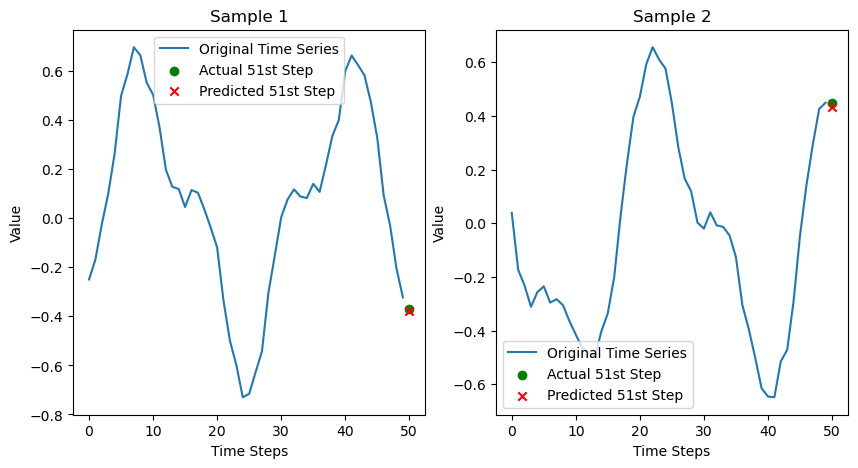

In [25]:
y_pred_rnn_2 = rnn_model_2.predict(X_test)
import matplotlib.pyplot as plt
num_samples = 2

plt.figure(figsize=(10, 5))

for i in range(num_samples):
    plt.subplot(1, 2, i+1)  
    plt.plot(np.arange(50), X_test[i, :, 0], label="Original Time Series") 
    plt.scatter(50, y_test[i], color='green', label="Actual 51st Step", marker='o')
    plt.scatter(50, y_pred_rnn_2[i], color='red', label="Predicted 51st Step", marker='x')
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.show()

### Comparing the results

In [26]:
results_df = pd.DataFrame(results)
evaluation_df = pd.DataFrame(evaluation)

In [27]:
results_df

,model,loss,mae,val_loss,val_mae
0,FCNN,0.001958,0.035507,0.002652,0.040999
1,RNN_1layer,0.070024,0.208538,0.068671,0.206443
2,RNN_2layer,0.002841,0.043219,0.002760,0.042131


In [28]:
evaluation_df

,model,MSE,MAE
0,FCNN,0.002701,0.041836
1,RNN_1layer,0.066318,0.203661
2,RNN_2layer,0.002762,0.042105


### Conclusion
- The FCNN outperforms with the lowest errors, followed closely by the RNN_2layer, while the RNN_1layer lags significantly with the highest error metrics.
- FCNN is the best overall choice for accuracy, while RNN_2layer can be considered if sequence modeling is required.